## Introduction to Tensorflow and Keras

> This notebook is a part of [AI for Beginners Curricula](http://github.com/microsoft/ai-for-beginners). Visit the repository for complete set of learning materials.

### Neural Frameworks

We have learnt that to train neural networks you need:
* Quickly multiply matrices (tensors)
* Compute gradients to perform gradient descent optimization

What neural network frameworks allow you to do:
* Operate with tensors on whatever compute is available, CPU or GPU, or even TPU
* Automatically compute gradients (they are explicitly programmed for all built-in tensor functions)

Optionally:
* Neural Network constructor / higher level API (describe network as a sequence of layers)
* Simple training functions (`fit`, as in Scikit Learn)
* A number of optimization algorithms in addition to gradient descent
* Data handling abstractions (that will ideally work on GPU, too)

### Most Popular Frameworks

* Tensorflow 1.x - first widely available framework (Google). Allowed to define static computation graph, push it to GPU, and explicitly evaluate it
* PyTorch - a framework from Facebook that is growing in popularity
* Keras - higher level API on top of Tensorflow/PyTorch to unify and simplify using neural networks (Francois Chollet)
* Tensorflow 2.x + Keras - new version of Tensorflow with integrated Keras functionality, which supports **dynamic computation graph**, allowing to perform tensor operations very similar to numpy (and PyTorch)

We will consider Tensorflow 2.x and Keras. Make sure you have version 2.x.x of Tensorflow installed:
```
pip install tensorflow
```
or
```
conda install tensorflow
```

In [1]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

2.8.1


## Basic Concepts: Tensor

**Tensor** is a multi-dimensional array. It is very convenient to use tensors to represent different types of data:
* 400x400 - black-and-white picture
* 400x400x3 - color picture 
* 16x400x400x3 - minibatch of 16 color pictures
* 25x400x400x3 - one second of 25-fps video
* 8x25x400x400x3 - minibatch of 8 1-second videos

### Simple Tensors

You can easily create simple tensors from lists of np-arrays, or generate random ones:

In [2]:
import os
# suppress tensorflow info level log
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

a = tf.constant([[1,2],[3,4]])
print(a)
a = tf.random.normal(shape=(10,3))
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 2.0577393   0.0970953  -0.05385915]
 [ 0.33814982 -0.04271309  1.0726138 ]
 [ 0.32983685  0.10554593  1.182453  ]
 [-1.8035941  -0.26384324  1.517676  ]
 [ 0.66853225  0.305595   -1.1930969 ]
 [ 0.47895896  0.05151679  1.7130157 ]
 [ 0.703724   -2.1262088  -1.644786  ]
 [-0.69420767  1.603348   -0.46460158]
 [-0.59113634 -0.93255126  0.24616304]
 [-1.091356    0.12486736 -1.6696877 ]], shape=(10, 3), dtype=float32)


You can use arithmetic operations on tensors, which are performed element-wise, as in numpy. Tensors are automatically expanded to required dimension, if needed. To extract numpy-array from tensor, use `.numpy()`:

In [3]:
print(a-a[0])
print(tf.exp(a)[0].numpy())

tf.Tensor(
[[ 0.          0.          0.        ]
 [-1.7195895  -0.13980839  1.126473  ]
 [-1.7279024   0.00845063  1.2363122 ]
 [-3.8613334  -0.36093855  1.5715351 ]
 [-1.389207    0.20849971 -1.1392378 ]
 [-1.5787803  -0.04557851  1.7668748 ]
 [-1.3540152  -2.223304   -1.5909269 ]
 [-2.751947    1.5062528  -0.41074243]
 [-2.6488757  -1.0296465   0.30002218]
 [-3.1490953   0.02777206 -1.6158286 ]], shape=(10, 3), dtype=float32)
[7.828252   1.1019654  0.94756556]


## Variables

Variables are useful to represent tensor values that can be modified using `assign` and `assign_add`. They are often used to represent neural network weights.

As an example, here is a silly way to get a sum of all rows of tensor `a`:

In [4]:
s = tf.Variable(tf.zeros_like(a[0]))
for i in a:
  s.assign_add(i)

print(s)

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.39664686, -1.077348  ,  0.7058904 ], dtype=float32)>


Much better way to do it:

In [5]:
tf.reduce_sum(a,axis=0)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.39664686, -1.077348  ,  0.7058904 ], dtype=float32)>

## Computing Gradients

For back propagation, you need to compute gradients. This is done using `tf.GradientTape()` idiom:
 * Add `with tf.GradientTape` block around our computations
 * Mark those tensors with respect to which we need to compute gradients by calling `tape.watch` (all variables are watched automatically)
 * Compute whatever we need (build computational graph)
 * Obtain gradients using `tape.gradient` 

In [6]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

with tf.GradientTape() as tape:
  tape.watch(a)  # Start recording the history of operations applied to `a`
  c = tf.sqrt(tf.square(a) + tf.square(b))  # Do some math using `a`
  # What's the gradient of `c` with respect to `a`?
  dc_da = tape.gradient(c, a)
  print(dc_da)

tf.Tensor(
[[-0.57835495  0.8814338 ]
 [ 0.17721884  0.52381796]], shape=(2, 2), dtype=float32)


## Example 1: Linear Regression

Now we know enough to solve the classical problem of **Linear regression**. Let's generate small synthetic dataset:

In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
import random

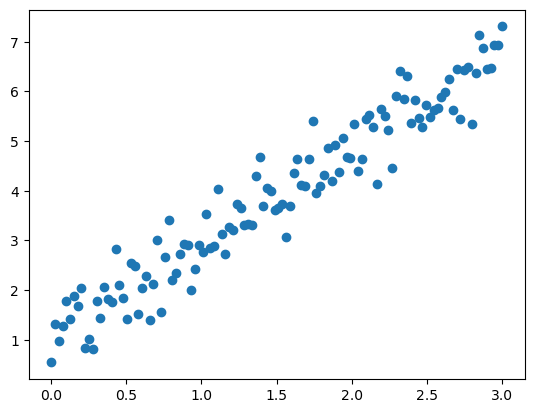

In [8]:
# pick the seed for reproducability - change it to explore the effects of random variations
random.seed(13)
np.random.seed(13)
tf.random.set_seed(13)

train_x = np.linspace(0, 3, 120)
train_labels = 2 * train_x + 0.9 + np.random.randn(*train_x.shape) * 0.5

plt.scatter(train_x,train_labels)

Linear regression is defined by a straight line $f_{W,b}(x) = Wx+b$, where $W, b$ are model parameters that we need to find. An error on our dataset $\{x_i,y_u\}_{i=1}^N$ (also called **loss function**) can be defined as mean square error:
$$
\mathcal{L}(W,b) = {1\over N}\sum_{i=1}^N (f_{W,b}(x_i)-y_i)^2
$$

Let's define our model and loss function:

In [9]:
input_dim = 1
output_dim = 1
learning_rate = 0.1

# This is our weight matrix
w = tf.Variable([[100.0]])
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def f(x):
  return tf.matmul(x,w) + b

def compute_loss(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))

We will train the model on a series of minibatches. We will use gradient descent, adjusting model parameters using the following formulae:
$$
\begin{array}{l}
W^{(n+1)}=W^{(n)}-\eta\frac{\partial\mathcal{L}}{\partial W} \\
b^{(n+1)}=b^{(n)}-\eta\frac{\partial\mathcal{L}}{\partial b} \\
\end{array}
$$

In [10]:
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = f(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

Let's do the training. We will do several passes through the dataset (so-called **epochs**), divide it into minibatches and call the function defined above:

In [11]:
# Shuffle the data.
indices = np.random.permutation(len(train_x))
features = tf.constant(train_x[indices],dtype=tf.float32)
labels = tf.constant(train_labels[indices],dtype=tf.float32)

In [12]:
batch_size = 4
for epoch in range(10):
  for i in range(0,len(features),batch_size):
    loss = train_on_batch(tf.reshape(features[i:i+batch_size],(-1,1)),tf.reshape(labels[i:i+batch_size],(-1,1)))
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 94.5247
Epoch 1: last batch loss = 9.3428
Epoch 2: last batch loss = 1.4166
Epoch 3: last batch loss = 0.5224
Epoch 4: last batch loss = 0.3807
Epoch 5: last batch loss = 0.3495
Epoch 6: last batch loss = 0.3413
Epoch 7: last batch loss = 0.3390
Epoch 8: last batch loss = 0.3384
Epoch 9: last batch loss = 0.3382


We now have obtained optimized parameters $W$ and $b$. Note that their values are similar to the original values used when generating the dataset ($W=2, b=1$)

In [13]:
w,b

(<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[1.8616778]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.0710956], dtype=float32)>)

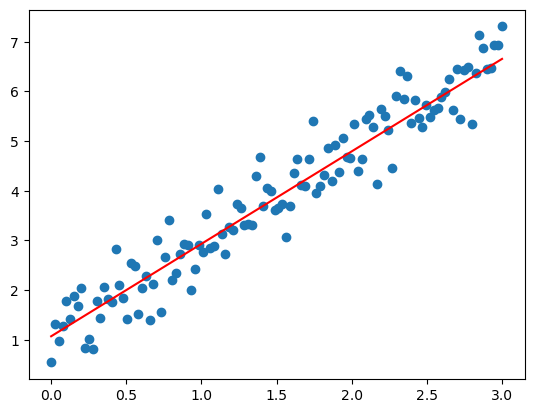

In [14]:
plt.scatter(train_x,train_labels)
x = np.array([min(train_x),max(train_x)])
y = w.numpy()[0,0]*x+b.numpy()[0]
plt.plot(x,y,color='red')

## Computational Graph and GPU Computations

Whenever we compute tensor expression, Tensorflow builds a computational graph that can be computed on the available computing device, e.g. CPU or GPU. Since we were using arbitrary Python function in our code, they cannot be included as part of computational graph, and thus when running our code on GPU we would need to pass the data between CPU and GPU back and forth, and compute custom function on CPU.

Tensorflow allows us to mark our Python function using `@tf.function` decorator, which will make this function a part of the same computational graph. This decorator can be applied to functions that use standard Tensorflow tensor operations. 

In [15]:
@tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = f(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

The code has not changed, but if you were running this code on GPU and on larger dataset - you would have noticed the difference in speed. 

## Dataset API

Tensorflow contains a convenient API to work with data. Let's try to use it. We will also train our model from scratch.

In [16]:
w.assign([[10.0]])
b.assign([0.0])

# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((train_x.astype(np.float32), train_labels.astype(np.float32)))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(tf.reshape(x,(-1,1)), tf.reshape(y,(-1,1)))
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 173.4585
Epoch 1: last batch loss = 13.8459
Epoch 2: last batch loss = 4.5407
Epoch 3: last batch loss = 3.7364
Epoch 4: last batch loss = 3.4334
Epoch 5: last batch loss = 3.1790
Epoch 6: last batch loss = 2.9458
Epoch 7: last batch loss = 2.7311
Epoch 8: last batch loss = 2.5332
Epoch 9: last batch loss = 2.3508


## Example 2: Classification

Now we will consider binary classification problem. A good example of such a problem would be a tumour classification between malignant and benign based on it's size and age.

The core model is similar to regression, but we need to use different loss function. Let's start by generating sample data:


In [17]:
np.random.seed(0) # pick the seed for reproducibility - change it to explore the effects of random variations

n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.05,class_sep=1.5)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

split = [ 70*n//100, (15+70)*n//100 ]
train_x, valid_x, test_x = np.split(X, split)
train_labels, valid_labels, test_labels = np.split(Y, split)

In [18]:
def plot_dataset(features, labels, W=None, b=None):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')
    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    if W is not None:
        min_x = min(features[:,0])
        max_x = max(features[:,0])
        min_y = min(features[:,1])*(1-.1)
        max_y = max(features[:,1])*(1+.1)
        cx = np.array([min_x,max_x],dtype=np.float32)
        cy = -(W[0]*cx+b)/W[1]
        ax.plot(cx,cy,'g')
        ax.set_ylim(min_y,max_y)
    plt.show()

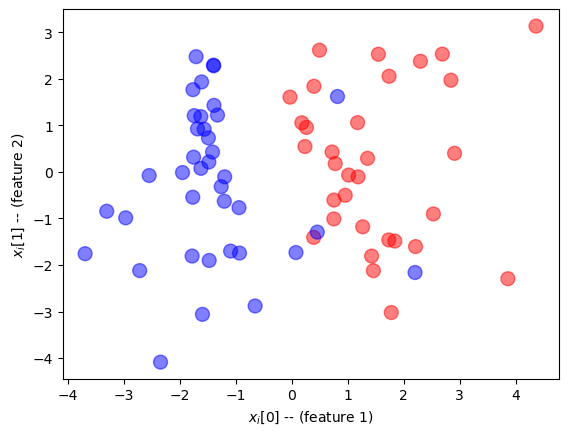

In [19]:
plot_dataset(train_x, train_labels)

## Normalizing Data

Before training, it is common to bring our input features to the standard range of [0,1] (or [-1,1]). The exact reasons for that we will discuss later in the course, but in short the reason is the following. We want to avoid values that flow through our network getting too big or too small, and we normally agree to keep all values in the small range close to 0. Thus we initialize the weights with small random numbers, and we keep signals in the same range.

When normalizing data, we need to subtract min value and divide by range. We compute min value and range using training data, and then normalize test/validation dataset using the same min/range values from the training set. This is because in real life we will only know the training set, and not all incoming new values that the network would be asked to predict. Occasionally, the new value may fall out of the [0,1] range, but that's not crucial.  

In [20]:
train_x_norm = (train_x-np.min(train_x)) / (np.max(train_x)-np.min(train_x))
valid_x_norm = (valid_x-np.min(train_x)) / (np.max(train_x)-np.min(train_x))
test_x_norm = (test_x-np.min(train_x)) / (np.max(train_x)-np.min(train_x))

## Training One-Layer Perceptron

Let's use Tensorflow gradient computing machinery to train one-layer perceptron.

Our neural network will have 2 inputs and 1 output. The weight matrix $W$ will have size $2\times1$, and bias vector $b$ -- $1$.

Core model will be the same as in previous example, but loss function will be a logistic loss. To apply logistic loss, we need to get the value of **probability** as the output of our network, i.e. we need to bring the output $z$ to the range [0,1] using `sigmoid` activation function: $p = \sigma(z) = \displaystyle\frac{1}{1 + e^{-z}}$.

Let's plot the `sigmoid` function to see what it looks like.

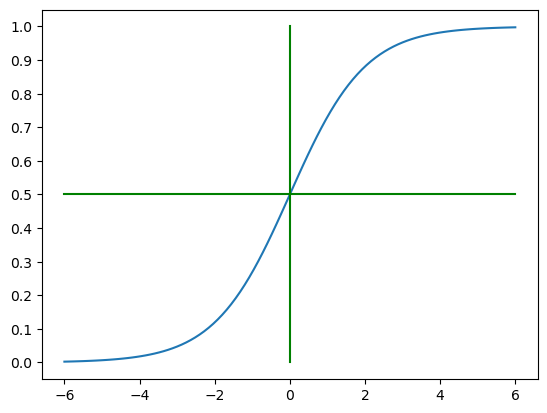

In [21]:
def plot_sigmoid():
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(-6, 6, 101)
    y = 1 / (1 + np.exp(-x))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.plot(x, y)
    ax.plot([-6, 6], [0.5, 0.5], 'g')
    ax.plot([0, 0], [0, 1], 'g')
    plt.show()

plot_sigmoid()

As you can see, we have $p > 0.5$ when $x > 0$ and $p \le 0.5$ when $x \le 0$. So if the output of the linear layer is positive, it is more likely to belong to class 1. If the output of the linear layer is 0 or negative, it is more likely to belong to class 0.

If we get the probability $p_i$ for the i-th input value corresponding to the actual class $y_i\in\{0,1\}$, we compute the loss as $\mathcal{L_i}=-(y_i\log p_i + (1-y_i)\log(1-p_i))$. 

In Tensorflow, both those steps (applying sigmoid and then logistic loss) can be done using one call to `sigmoid_cross_entropy_with_logits` function. Since we are training our network in minibatches, we need to average out the loss across all elements of a minibatch using `reduce_mean`: 

In [22]:
W = tf.Variable(tf.random.normal(shape=(2,1)),dtype=tf.float32)
b = tf.Variable(tf.zeros(shape=(1,),dtype=tf.float32))

learning_rate = 0.1

@tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    z = tf.matmul(x, W) + b
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=z))
  dloss_dw, dloss_db = tape.gradient(loss, [W, b])
  W.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

We will use minibatches of 8 elements, and do a few epochs of training:

In [23]:
# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((train_x_norm.astype(np.float32), train_labels.astype(np.float32)))
dataset = dataset.shuffle(128).batch(8)

for epoch in range(1, 101):
  loss_list = []
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, tf.expand_dims(y,1))
    loss_list.append(float(loss))
  if epoch % 10 == 0:
    print('Epoch %d: avg loss = %.4f' % (epoch, sum(loss_list) / len(loss_list)))

Epoch 10: avg loss = 0.7165
Epoch 20: avg loss = 0.6637
Epoch 30: avg loss = 0.6182
Epoch 40: avg loss = 0.5755
Epoch 50: avg loss = 0.5457
Epoch 60: avg loss = 0.5159
Epoch 70: avg loss = 0.4915
Epoch 80: avg loss = 0.4701
Epoch 90: avg loss = 0.4509
Epoch 100: avg loss = 0.4328


To make sure our training worked, let's plot the line that separates two classes. Separation line is defined by the equation $W\times x + b = 0$

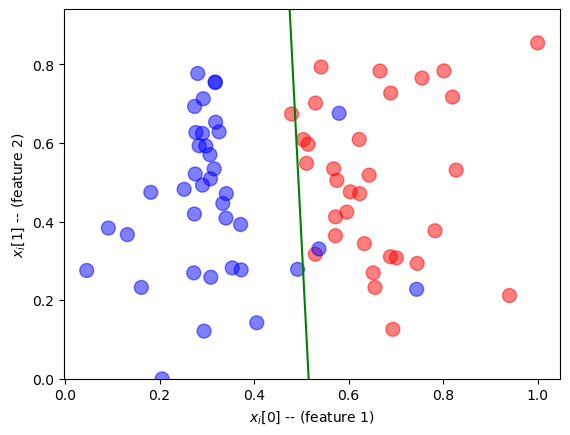

In [24]:
plot_dataset(train_x_norm,train_labels,W.numpy(),b.numpy())

Let's see how our model behaves on the validation data.

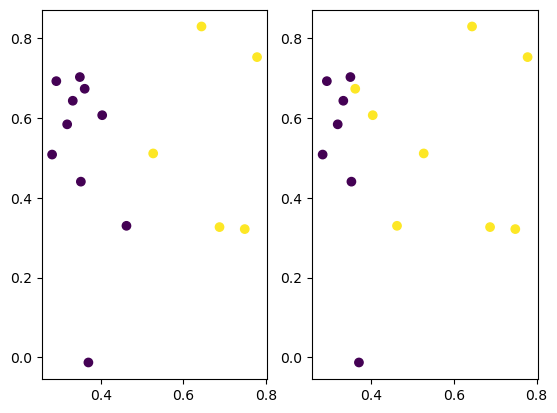

In [25]:
pred = tf.matmul(valid_x_norm,W)+b
fig,ax = plt.subplots(1,2)
ax[0].scatter(valid_x_norm[:,0],valid_x_norm[:,1],c=pred[:,0]>0)
ax[1].scatter(valid_x_norm[:,0],valid_x_norm[:,1],c=valid_labels)

To compute the accuracy on the validation data, we can cast boolean type to float, and compute the mean:

In [26]:
tf.reduce_mean(tf.cast(((pred[:,0]>0)==valid_labels),tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

Let's explain what goes on here:
* `pred` is the values predicted by the network. They are not quite probabilities, because we have not used an activation function, but values greater than 0 correspond to class 1, and smaller - to class 0.
*  `pred[0]>0` creates a boolean tensor of results, where `True` corresponds to class 1, and `False` - to class 0
* We compare that tensor to expected labels `valid_labels`, getting the boolean vector or correct predictions, where `True` corresponds to the correct prediction, and `False` - to incorrect one.
* We convert that tensor to floating point using `tf.cast`
* We then compute the mean value using `tf.reduce_mean` - that is exactly our desired accuracy  

And finally, let's test our model by running it against the test data.

In [27]:
pred = tf.matmul(test_x_norm,W)+b
tf.reduce_mean(tf.cast(((pred[:,0]>0)==test_labels),tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

## Using TensorFlow/Keras Optimizers

Tensorflow is closely integrated with Keras, which contains a lot of useful functionality. For example, we can use different **optimization algorithms**. Let's do that, and also print obtained accuracy during training.

In [28]:
optimizer = tf.keras.optimizers.Adam(0.1)

W = tf.Variable(tf.random.normal(shape=(2,1)))
b = tf.Variable(tf.zeros(shape=(1,),dtype=tf.float32))

@tf.function
def train_on_batch(x, y):
  vars = [W, b]
  with tf.GradientTape() as tape:
    z = tf.sigmoid(tf.matmul(x, W) + b)
    loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(z,y))
    correct_prediction = tf.equal(tf.round(y), tf.round(z))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    grads = tape.gradient(loss, vars)
    optimizer.apply_gradients(zip(grads,vars))
  return loss,acc

for epoch in range(1, 16):
  loss_list, acc_list = [], []
  for step, (x, y) in enumerate(dataset):
    loss,acc = train_on_batch(tf.reshape(x,(-1,2)), tf.reshape(y,(-1,1)))
    loss_list.append(float(loss))
    acc_list.append(float(acc))
  print('Epoch %d: avg loss = %.4f, avg acc = %.4f' % (epoch, sum(loss_list) / len(loss_list), sum(acc_list) / len(acc_list)))

Epoch 1: avg loss = 7.6091, avg acc = 0.5324
Epoch 2: avg loss = 7.4385, avg acc = 0.5324
Epoch 3: avg loss = 6.9971, avg acc = 0.5694
Epoch 4: avg loss = 6.7028, avg acc = 0.6759
Epoch 5: avg loss = 6.3789, avg acc = 0.7407
Epoch 6: avg loss = 6.0970, avg acc = 0.7778
Epoch 7: avg loss = 5.7900, avg acc = 0.8426
Epoch 8: avg loss = 5.5753, avg acc = 0.8704
Epoch 9: avg loss = 5.3010, avg acc = 0.8889
Epoch 10: avg loss = 5.0722, avg acc = 0.9167
Epoch 11: avg loss = 4.8806, avg acc = 0.8750
Epoch 12: avg loss = 4.6787, avg acc = 0.9028
Epoch 13: avg loss = 4.5439, avg acc = 0.9120
Epoch 14: avg loss = 4.3528, avg acc = 0.8750
Epoch 15: avg loss = 4.2136, avg acc = 0.8704


**Task 1**: Plot the graphs of loss function and accuracy on training and validation data during training

**Task 2**: Try to solve MNIST classificiation problem using this code. Hint: use `softmax_crossentropy_with_logits` or `sparse_softmax_cross_entropy_with_logits` as loss function. In the first case you need to feed expected output values in *one hot encoding*, and in the second case - as integer class number.

## Keras
### Deep Learning for Humans

* Keras is a library originally developed by Francois Chollet to work on top of Tensorflow, CNTK and Theano, to unify all lower-level frameworks. You can still install Keras as a separate library, but it is not advised to do so. 
* Now Keras is included as part of Tensorflow library
* You can easily construct neural networks from layers
* Contains `fit` function to do all training, plus a lot of functions to work with typical data (pictures, text, etc.)
* A lot of samples
* Functional API vs. Sequential API

Keras provides higher level abstractions for neural networks, allowing us to operate in terms of layers, models and optimizers, and not in terms of tensors and gradients.  

Classical Deep Learning book from the creator of Keras: [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)

### Functional API

When using functional API, we define the **input** to the network as `keras.Input`, and then compute the **output** by passing it through a series of computations. Finally, we define **model** as an object that transforms input into output.

Once we obtained **model** object, we need to:
* **Compile it**, by specifying loss function and the optimizer that we want to use with our model
* **Train it** by calling `fit` function with the training (and possibly validation) data
* **Test it** by calling `evaluate` function with the test data

In [29]:
inputs = tf.keras.Input(shape=(2,))
z = tf.keras.layers.Dense(1,kernel_initializer='glorot_uniform',activation='sigmoid')(inputs)
model = tf.keras.models.Model(inputs,z)

model.compile(tf.keras.optimizers.Adam(0.1),'binary_crossentropy',['accuracy'])
model.summary()
h = model.fit(train_x_norm,train_labels,validation_data=(valid_x_norm,valid_labels),batch_size=8,epochs=15)
print('Test result:')
model.evaluate(test_x_norm,test_labels)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
9/9 [==============================] - 0s 14ms/step - loss: 0.7333 - accuracy: 0.5429 - val_loss: 0.7004 - val_accuracy: 0.4000
Epoch 2/15
9/9 [==============================] - 0s 4ms/step - loss: 0.7025 - accuracy: 0.4714 - val_loss: 0.6573 - val_accuracy: 0.5333
Epoch 3/15
9/9 [==============================] - 0s 5ms/step - loss: 0.6534 - accuracy: 0.6000 - val_loss: 0.6380 - val_accuracy: 0.8000
Epoch 4/15
9/9 [==============================] 

[0.31617286801338196, 1.0]

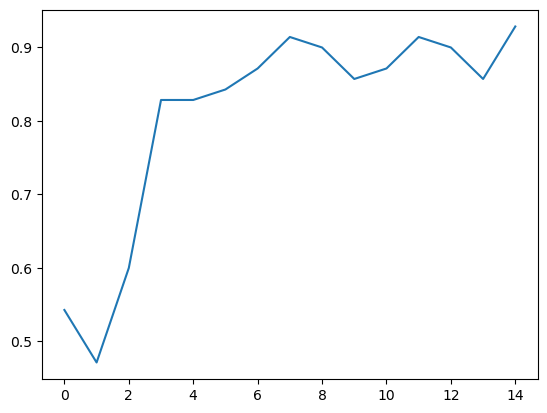

In [30]:
plt.plot(h.history['accuracy'])

### Sequential API

Alternatively, we can start thinking of a model as of a **sequence of layers**, and just specify those layers by adding them to the `model` object:

In [31]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(5,activation='sigmoid',input_shape=(2,)))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.compile(tf.keras.optimizers.Adam(0.1),'binary_crossentropy',['accuracy'])
model.summary()
model.fit(train_x_norm,train_labels,validation_data=(valid_x_norm,valid_labels),batch_size=8,epochs=15)
print('Test result:')
model.evaluate(test_x_norm,test_labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 5)                 15        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
9/9 [==============================] - 0s 13ms/step - loss: 0.7810 - accuracy: 0.4286 - val_loss: 0.7540 - val_accuracy: 0.4667
Epoch 2/15
9/9 [==============================] - 0s 4ms/step - loss: 0.7238 - accuracy: 0.3857 - val_loss: 0.6867 - val_accuracy: 0.5333
Epoch 3/15
9/9 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5143 - val_loss: 0.6910 - val_accuracy: 0.4667
Epoch 4/15
9/9 [=========================

[0.08642062544822693, 1.0]

## Classification Loss Functions

It is important to correctly specify loss function and activation function on the last layer of the network. The main rules are the following:
* If the network has one output (**binary classification**), we use **sigmoid** activation function, for **multiclass classification** - **softmax**
* If the output class is represented as one-hot-encoding, the loss function will be **cross entropy loss** (categorical cross-entropy), if the output contains class number - **sparse categorical cross-entropy**.  For **binary classification** - use **binary cross-entropy** (same as **log loss**)
* **Multi-label classification** is when we can have an object belonging to several classes at the same time. In this case, we need to encode labels using one-hot encoding, and use **sigmoid** as activation function, so that each class probability is between 0 and 1.

| Classification | Label Format | Activation Function | Loss |
|---------------|-----------------------|-----------------|----------|
| Binary      | Probability of 1st class | sigmoid | binary crossentropy |
| Binary      | One-hot encoding (2 outputs) | softmax | categorical crossentropy |
| Multiclass |  One-hot encoding | softmax | categorical crossentropy |
| Multiclass | Class Number | softmax | sparse categorical crossentropy |
| Multilabel | One-hot encoding | sigmoid | categorical crossentropy |

> Binary classification can also be handled as a special case of multi-class classification with two outputs. In this case, we need to use **softmax**.


**Task 3**: 
Use Keras to train MNIST classifier:
* Notice that Keras contains some standard datasets, including MNIST. To use MNIST from Keras, you only need a couple of lines of code (more information [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist))
* Try several network configuration, with different number of layers/neurons, activation functions.

What is the best accuracy you were able to achieve?

## Takeaways

* Tensorflow allows you to operate on tensors at low level, you have most flexibility.
* There are convenient tools to work with data (`td.Data`) and layers (`tf.layers`)
* For beginners/typical tasks, it is recommended to use **Keras**, which allows to construct networks from layers
* If non-standard architecture is needed, you can implement your own Keras layer, and then use it in Keras models
* It is a good idea to look at PyTorch as well and compare approaches. 

A good sample notebook from the creator of Keras on Keras and Tensorflow 2.0 can be found [here](https://t.co/k694J95PI8).